# Group 14 - Project FP01
## Time series anomaly detection - Random Forest

In [25]:
import os
import time
import tsfel
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from plots import *
from dataset import *
from metrics import *
from models_functions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [26]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Various parameters

In [27]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

freq_str = freq.replace(".", "_")
features_folder_normal = f"./features/normal{freq_str}/"
features_folder_collisions = f"./features/collisions{freq_str}/"

#### Data

In [28]:
# df_features_normal, df_normal_raw, _, action2int_normal_raw = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, features_folder=f"{features_folder_normal}", get_action2int=True)
# df_features_collisions, df_collisions_raw, df_collisions_raw_action, action2int_collisions_raw = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, features_folder=f"{features_folder_collisions}1_5/", get_action2int=True)
# df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1, action2int_collisions_raw_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, features_folder=f"{features_folder_collisions}1/", get_action2int=True)
# df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5, action2int_collisions_raw_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, features_folder=f"{features_folder_collisions}5/", get_action2int=True)

In [29]:
df_features_normal, df_normal_raw, _, action2int_normal_raw = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, features_folder=None, get_action2int=True)
df_features_collisions, df_collisions_raw, df_collisions_raw_action, action2int_collisions_raw = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, features_folder=None, get_action2int=True)
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1, action2int_collisions_raw_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, features_folder=None, get_action2int=True)
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5, action2int_collisions_raw_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, features_folder=None, get_action2int=True)

Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
--- 148.482351064682 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 48.05001926422119 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


--- 29.51949954032898 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
--- 23.774187564849854 seconds ---


In [30]:
df_train, df_test = train_test_split(df_features_normal)

In [31]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [32]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
# num_classes = len(set(y_train))
# y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

### Collisions

In [33]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [34]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

### Random forest classifier

In [35]:
num_estims = [10, 100, 1000]
crits = ['gini', 'entropy', 'log_loss']
max_dept = [None, 50, 100, 1000]
min_s_splits = [2, 3]
max_features = ['sqrt', 'log2', None]

classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = 1000,
    min_samples_split = 2,
    max_features = 'sqrt',
)
# Train the RandomForestClassifier on normal data
classifier.fit(X_train, y_train)
print("Random Forest training completed.")

Random Forest training completed.


In [36]:
y_test_predict = classifier.predict_proba(X_test.values)

Check the model performance

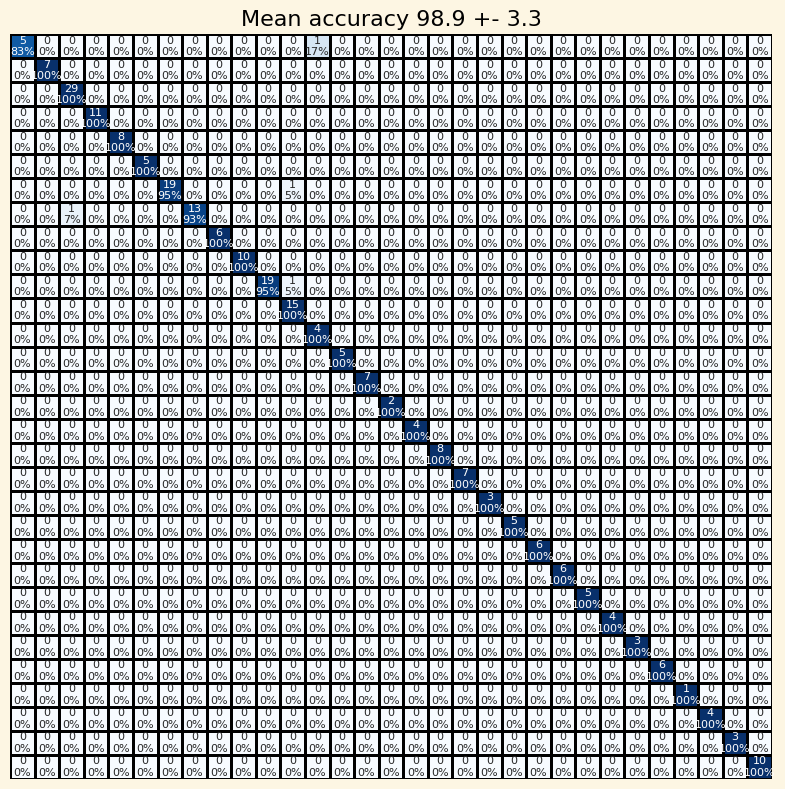

In [37]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int_normal_raw.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_normal_raw.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_normal_raw.values()], fontsize=8, xrotation=90)
plt.tight_layout()

## Compute uncertainty

In [38]:
def compute_uncertainty_dict(preds_array, preds_bayes_mean, y_true):
    uncertainties_bayes = dict()
    uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_true), :]).compute_uncertainty_metrics()
    uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_true), :]).compute_uncertainty_metrics()
    uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()
    return uncertainties_bayes

In [39]:
def plot_uncertainty(uncertainties_bayes):
    fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
    for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
        for idx, key in enumerate(['wrong', 'correct', 'all']):
            data = uncertainties_bayes[key][measure]
            # Check if data is not empty and does not contain only NaNs
            if data.size > 0 and not np.all(np.isnan(data)):
                ax[idx].hist(data[~np.isnan(data)], color=["red", "green", "blue"][idx], log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5)
                ax[idx].set_title(f"{key.capitalize()} - {measure}")
            else:
                ax[idx].text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax[idx].transAxes)
                ax[idx].set_title(f"{key.capitalize()} - {measure}")

    fig.suptitle("Random forest", fontsize=20)
    plt.tight_layout()
    plt.show()

In [40]:
n_mc = 10
preds_array = np.array([classifier.predict_proba(X_test.values) for _ in range(n_mc)])
preds_bayes_mean = np.mean(np.array(preds_array), axis = 0)

In [41]:
uncertainties_bayes = compute_uncertainty_dict(preds_array, preds_bayes_mean, y_test)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


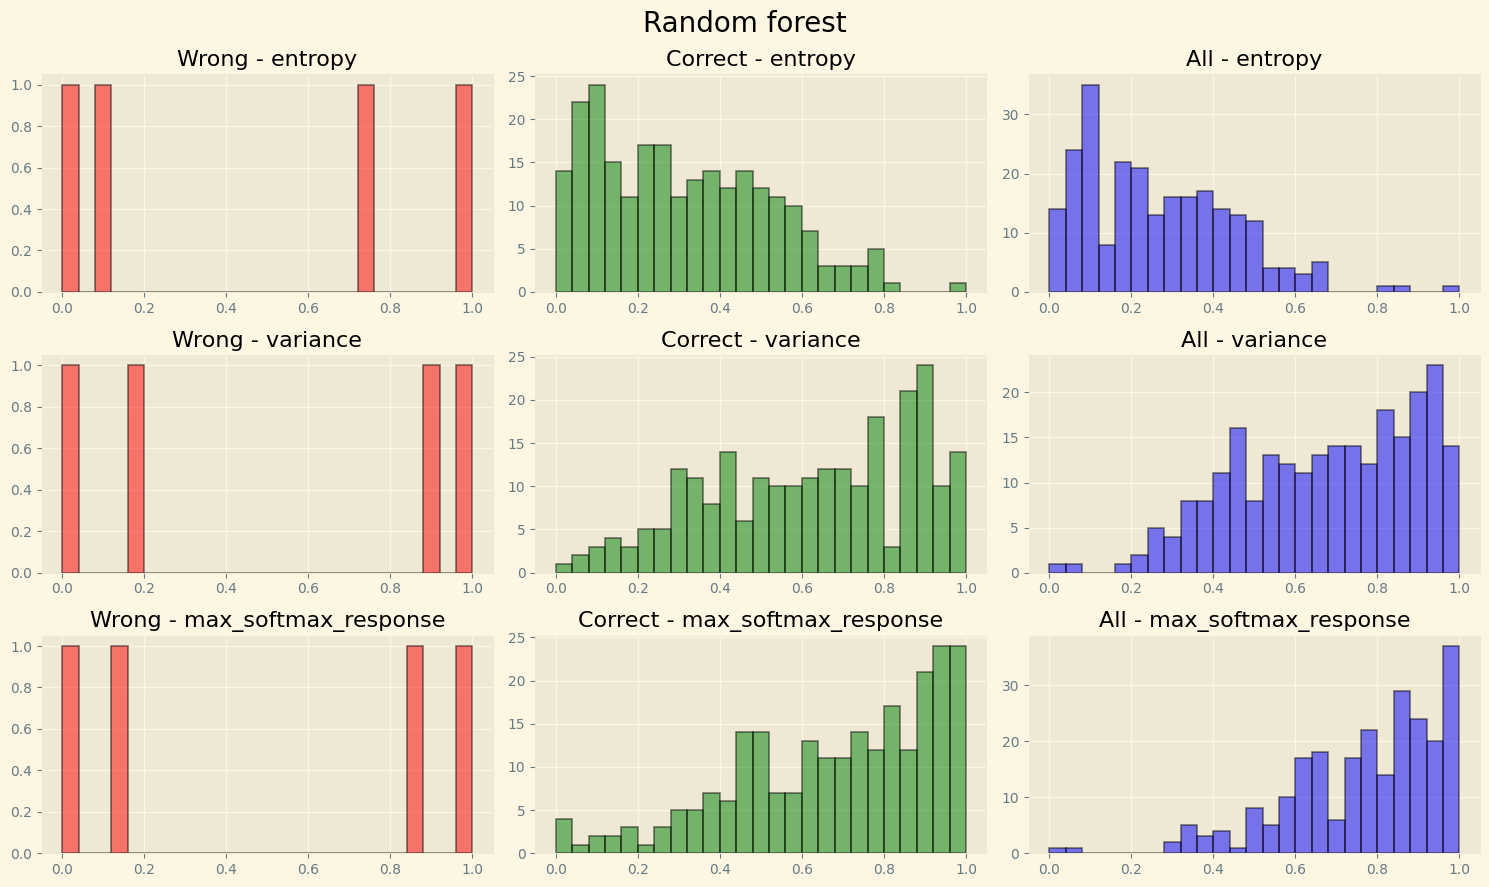

In [42]:
plot_uncertainty(uncertainties_bayes)

## Compute uncertainty

In [43]:
X_test = df_features_collisions.drop(["label", "start", "end"], axis=1)
y_test = df_features_collisions["label"]

X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                           columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()


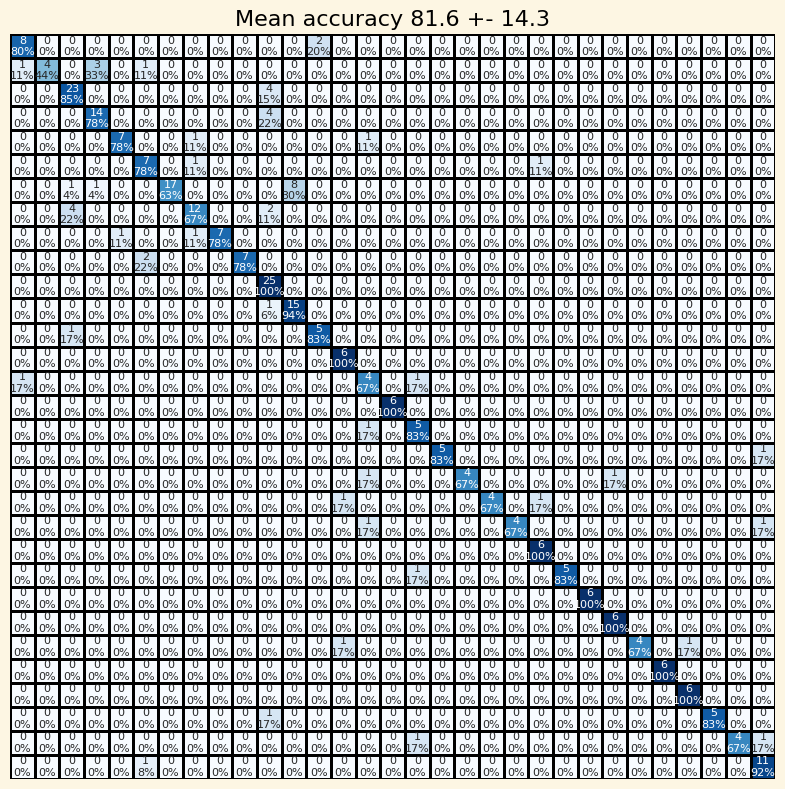

In [44]:
y_test_predict = classifier.predict_proba(X_test.values)

cm = confusion_matrix(y_test, y_test_predict.argmax(axis=1), labels=list(action2int_collisions_raw.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [45]:
preds_array_collisions = np.array([classifier.predict_proba(X_test.values) for _ in range(n_mc)])
preds_bayes_mean_collision = np.mean(np.array(preds_array_collisions), axis = 0)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


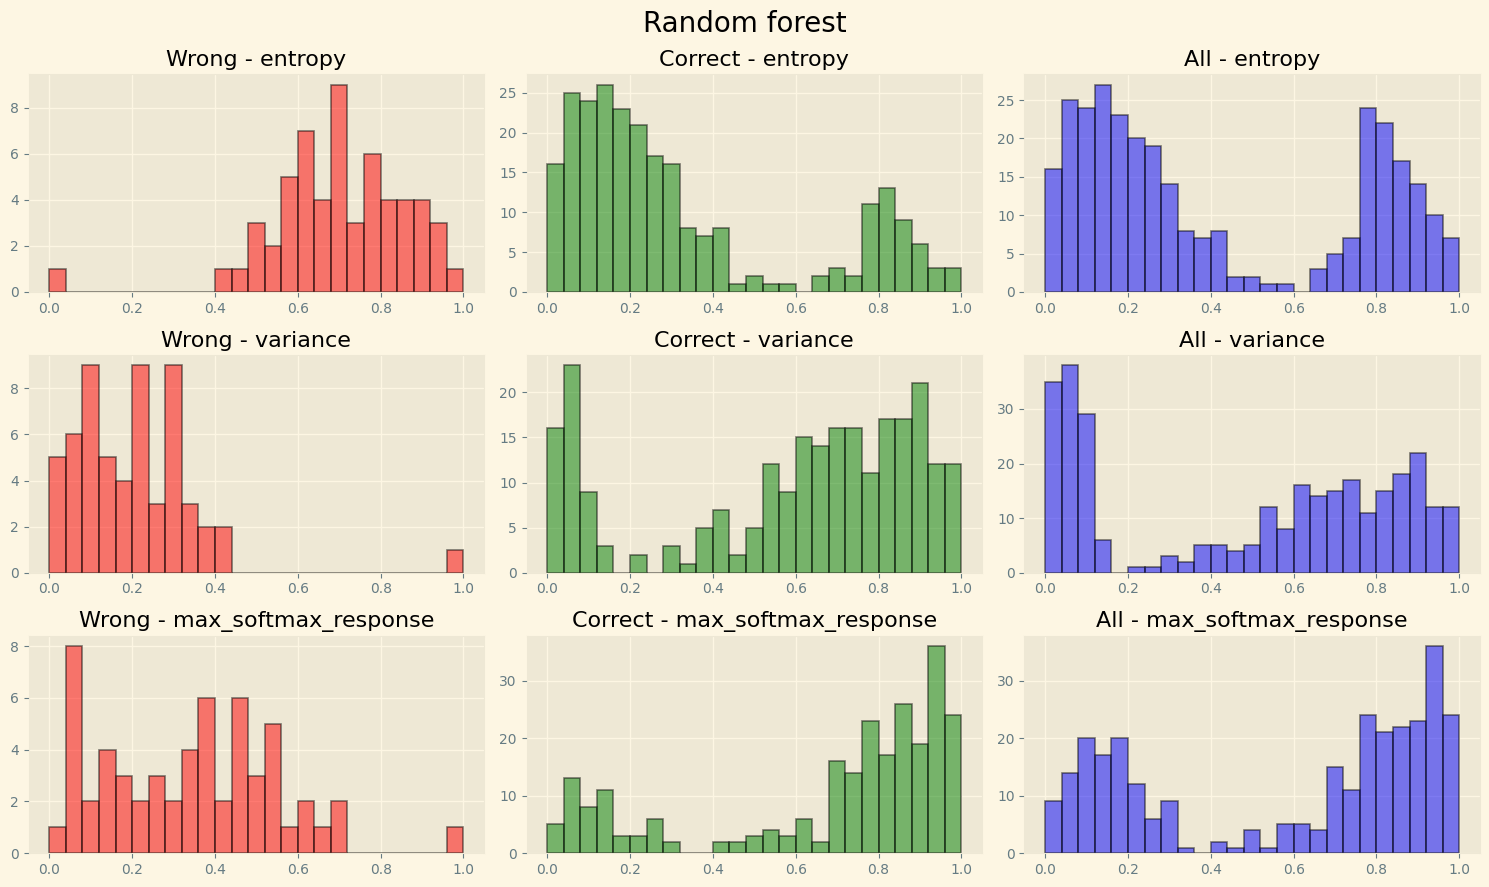

In [46]:
uncertainties_bayes_collisions = compute_uncertainty_dict(preds_array_collisions, preds_bayes_mean_collision, y_test)
plot_uncertainty(uncertainties_bayes_collisions)

In [47]:
X_test_1 = df_features_collisions_1.drop(["label", "start", "end"], axis=1)
y_test_1 = df_features_collisions_1["label"]

X_test_1 = pd.DataFrame(selector_variance.transform(scaler.transform(X_test_1)),
                            columns=X_test_1.columns.values[selector_variance.get_support()])
X_test_1.drop(corr_features, inplace=True, axis=1)
X_test_1 = X_test_1[selected_features].copy()

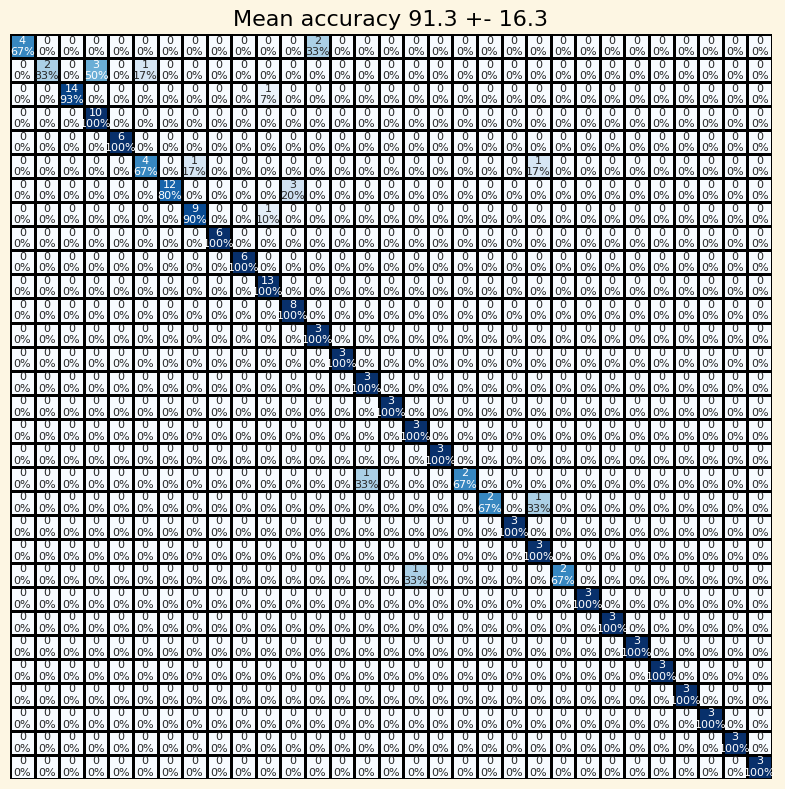

In [48]:
y_test_predict_1 = classifier.predict_proba(X_test_1.values)

cm = confusion_matrix(y_test_1, y_test_predict_1.argmax(axis=1), labels=list(action2int_collisions_raw_1.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw_1.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw_1.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [49]:
preds_array_collisions_1 = np.array([classifier.predict_proba(X_test_1.values) for _ in range(n_mc)])
preds_bayes_mean_collision_1 = np.mean(np.array(preds_array_collisions_1), axis = 0)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


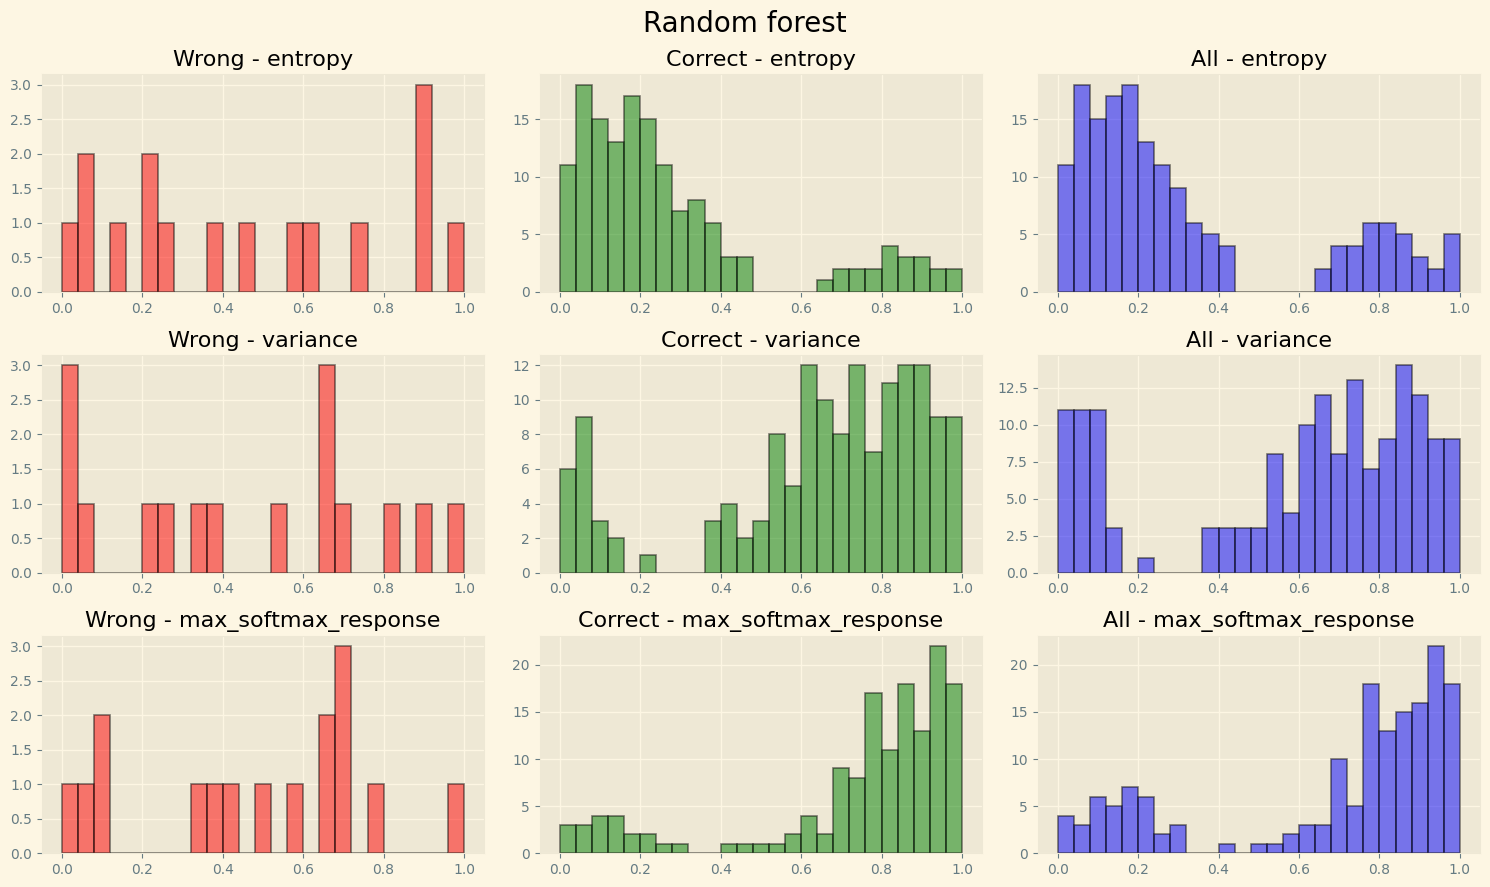

In [50]:
uncertainties_bayes_collisions_1 = compute_uncertainty_dict(preds_array_collisions_1, preds_bayes_mean_collision_1, y_test_1)
plot_uncertainty(uncertainties_bayes_collisions_1)

In [51]:
X_test_5 = df_features_collisions_5.drop(["label", "start", "end"], axis=1)
y_test_5 = df_features_collisions_5["label"]

X_test_5 = pd.DataFrame(selector_variance.transform(scaler.transform(X_test_5)),
                            columns=X_test_5.columns.values[selector_variance.get_support()])
X_test_5.drop(corr_features, inplace=True, axis=1)
X_test_5 = X_test_5[selected_features].copy()

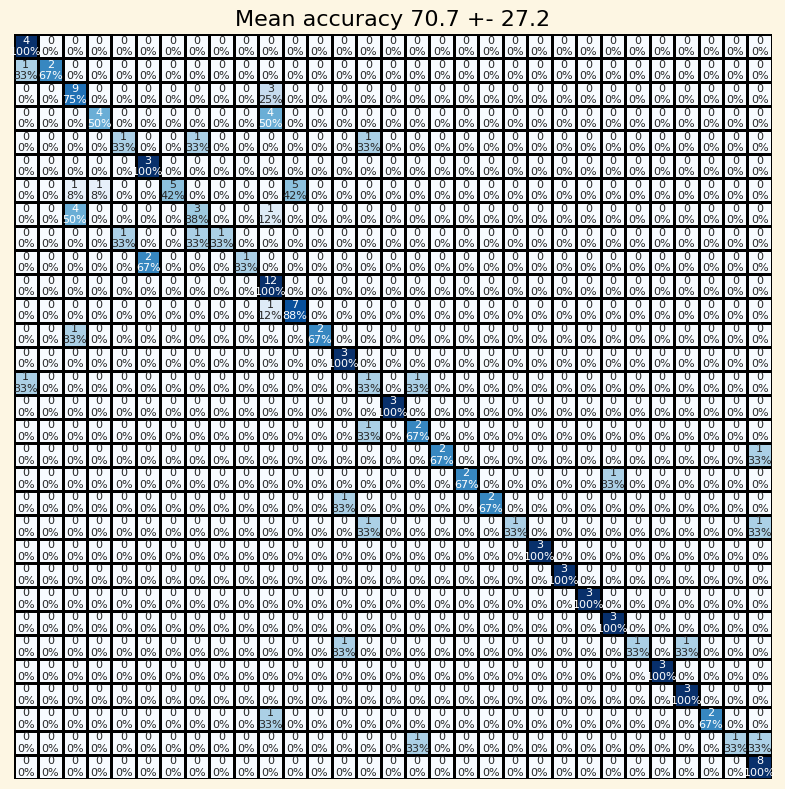

In [52]:
y_test_predict_5 = classifier.predict_proba(X_test_5.values)

cm = confusion_matrix(y_test_5, y_test_predict_5.argmax(axis=1), labels=list(action2int_collisions_raw_5.values()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
int2action = {v: k for k, v in action2int_collisions_raw_5.items()}
seaborn_cm(cm,
            ax,
            [int2action[l] for l in action2int_collisions_raw_5.values()], fontsize=8, xrotation=90)
plt.tight_layout()

In [53]:
preds_array_collisions_5 = np.array([classifier.predict_proba(X_test_5.values) for _ in range(n_mc)])
preds_bayes_mean_collision_5 = np.mean(np.array(preds_array_collisions_5), axis = 0)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


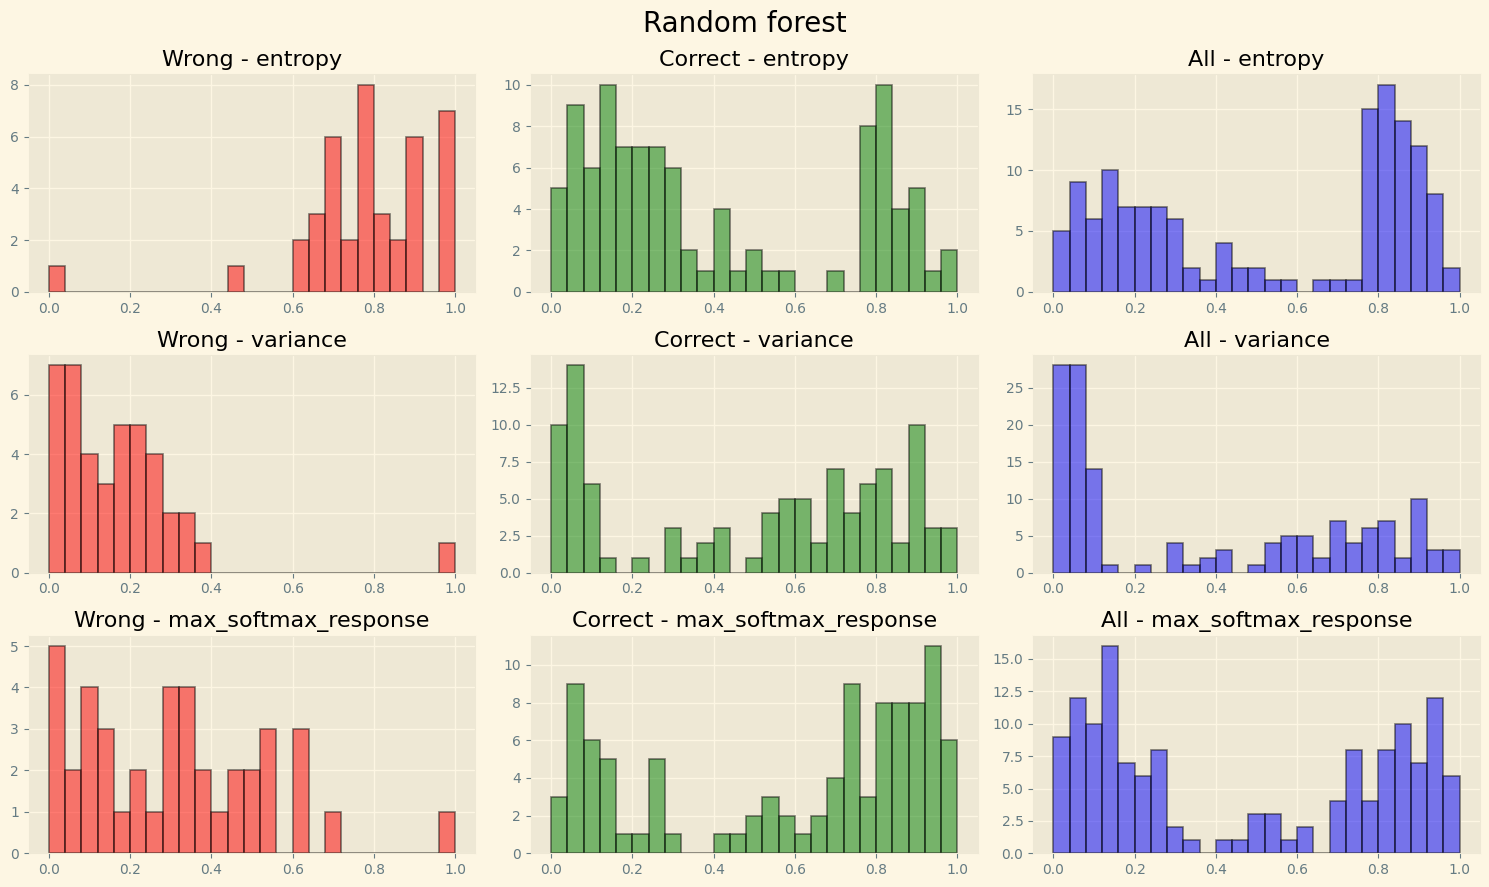

In [54]:
uncertainties_bayes_collisions_5 = compute_uncertainty_dict(preds_array_collisions_5, preds_bayes_mean_collision_5, y_test_5)
plot_uncertainty(uncertainties_bayes_collisions_5)

# Assess TAD algorithm performance via ROC curves

In [55]:
def plot_manual_roc(uncertainties_bayes, df_features_collisions, collisions_init):
    roc_dict = dict()
    for confidence_metric in uncertainties_bayes['correct'].keys():
        confidence = uncertainties_bayes['all'][confidence_metric]
        if confidence_metric == "entropy":
            confidence = 1- confidence
        sens = list()
        fpr = list()
        for threshold in np.arange(0, 1, 0.1):
            df_not_confident = df_features_collisions[confidence <= threshold]
            anomaly_indexes = list()
            tp = 0
            for anomaly in collisions_init:
                for index, row in df_not_confident.iterrows():
                    if anomaly >= row['start'] and anomaly <= row['end']:
                        anomaly_indexes.append(index)
                        tp += 1

            cm_anomaly = np.zeros((2, 2))
            n_samples = len(df_features_collisions)
            n_not_collisions = n_samples - len(collisions_init)
            n_detected = len(df_not_confident)

            fp = n_detected - tp
            fn = len(collisions_init) - tp
            tn = n_not_collisions - fp
            cm_anomaly[0][0] = tn
            cm_anomaly[1][1] = tp
            cm_anomaly[0][1] = fp
            cm_anomaly[1][0] = fn
            sens.append(tp / (tp + fn))
            fpr.append(1 - tn / (fp + tn))
        roc_dict[confidence_metric] = (fpr, sens)
    
    fig, ax = plt.subplots(1, 1)
    for confidence_metric in uncertainties_bayes['correct'].keys():
        ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
    ax.legend();

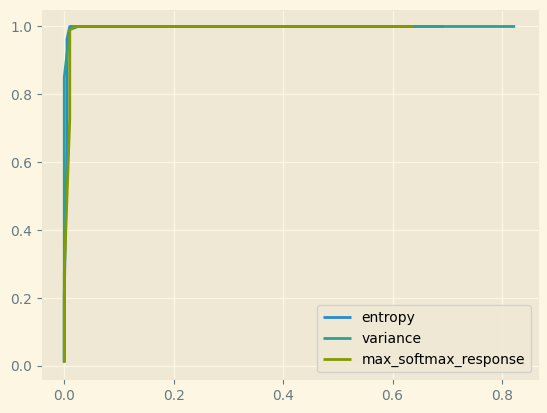

In [56]:
plot_manual_roc(uncertainties_bayes_collisions, df_features_collisions, collisions_init)

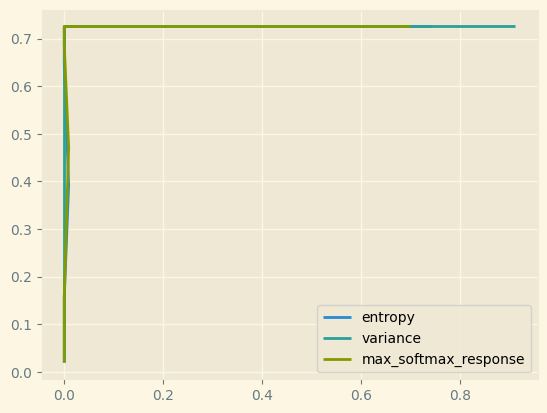

In [57]:
plot_manual_roc(uncertainties_bayes_collisions_1, df_features_collisions_1, collisions_init1)

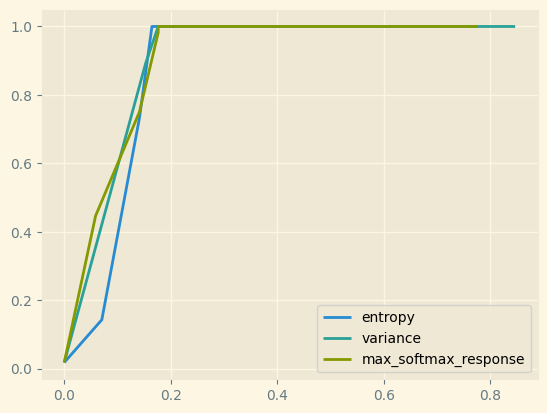

In [58]:
plot_manual_roc(uncertainties_bayes_collisions_5, df_features_collisions_5, collisions_init5)